In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

import dataset
import os

In [2]:
class ToQuantize(object):

    def __init__(self, centroids):
        self.centroids=centroids

    def __call__(self, pic):
        """
        Args:
            pic : batch of images.
            centroids : palette
        Returns:
            Tensor: Converted image.
        """
        return self.quantize(pic, self.centroids)

    def squared_euclidean_distance(self, a, b):
        b = torch.transpose(b, 0, 1)
        a2 = torch.sum(torch.square(a), dim=1, keepdims=True)
        b2 = torch.sum(torch.square(b), dim=0, keepdims=True)
        ab = torch.matmul(a, b)
        d = a2 - 2 * ab + b2
        return d


    def quantize(self, x, centroids):
        b = 1
        c, h, w = x.shape
        # [B, C, H, W] => [B, H, W, C]
        x = x.permute(1, 2, 0).contiguous()
        x = x.view(-1, c)  # flatten to pixels
        d = self.squared_euclidean_distance(x, centroids)
        x = torch.argmin(d, 1)
        x = x.view(h, w)
        return x

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [15]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def squared_euclidean_distance(a, b):
    b = torch.transpose(b, 0, 1)
    a2 = torch.sum(torch.square(a), dim=1, keepdims=True)
    b2 = torch.sum(torch.square(b), dim=0, keepdims=True)
    ab = torch.matmul(a, b)
    d = a2 - 2 * ab + b2
    return d

def quantize(x, centroids):
    b, c, h, w = x.shape
    # [B, C, H, W] => [B, H, W, C]
    x = x.permute(0, 2, 3, 1).contiguous()
    print(x.shape)
    x = x.view(-1, c)  # flatten to pixels
    print(x.shape)
    d = squared_euclidean_distance(x, centroids)
    x = torch.argmin(d, 1)
    print(x.shape)
    x = x.view(b, h, w)
    print(x.shape)
    return x

In [3]:
transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        ToQuantize(nn.Parameter(torch.from_numpy(np.load(f"/root/downloads/kmeans_centers.npy")), requires_grad=False))
    ])

In [4]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True,transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                            shuffle=True, num_workers=0)

Files already downloaded and verified


In [19]:
color_palette = np.load('/root/downloads/kmeans_centers.npy')

trainloader, testloader, train_origin = dataset.load_cifar(batch_size=32, palette=color_palette)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


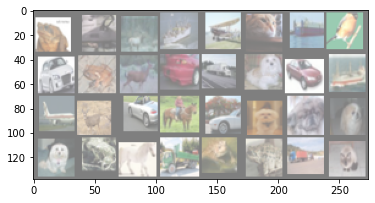

In [20]:
dataiter = iter(train_origin)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

torch.Size([32, 32, 32, 3])
torch.Size([32768, 3])
torch.Size([32768])
torch.Size([32, 32, 32])


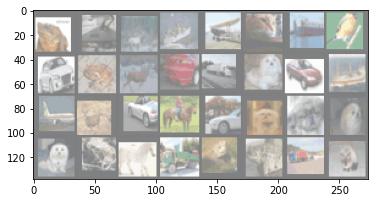

In [21]:


centroids = nn.Parameter(
            torch.from_numpy(color_palette), requires_grad=False
        )

re_img = color_palette[quantize(images, centroids)]
b=torch.Tensor(re_img)
b.shape
b = np.transpose(b, (0,3,1,2))
b.shape
imshow(torchvision.utils.make_grid(b))